## Imports

In [1]:
import tqdm, shap, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score

/home/matheusmbr/mambaforge/envs/tcc_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/PHASE1_PATIENTS_SAMPLE.csv')
df.drop(columns='subject_id', inplace=True)

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         7493 non-null   object 
 1   age_group                      7493 non-null   int64  
 2   weight_range                   7493 non-null   int64  
 3   idealweight_range              7493 non-null   int64  
 4   IMC_range                      7493 non-null   int64  
 5   daysinICU                      7493 non-null   int64  
 6   firstnutrition                 7493 non-null   int64  
 7   avgdaily_Kcal_firstICU7days    7493 non-null   float64
 8   avgdaily_KcalKg_firstICU7days  7493 non-null   float64
 9   avgdaily_Kcal_firstNT7days     7493 non-null   float64
 10  avgdaily_KcalKg_firstNT7days   7493 non-null   float64
 11  avgdaily_Kcal_ICUdays          7493 non-null   float64
 12  avgdaily_KcalKg_ICUdays        7493 non-null   f

In [4]:
df.nunique().reset_index().rename(columns={0: 'unique_values'}).sort_values(by='unique_values', ascending=False)

,index,unique_values
13,avgdaily_Kcal_NTdays,5137
9,avgdaily_Kcal_firstNT7days,5083
11,avgdaily_Kcal_ICUdays,5059
7,avgdaily_Kcal_firstICU7days,4992
21,avgdaily_g_NTdays,948
17,avgdaily_g_firstNT7days,932
19,avgdaily_g_ICUdays,827
15,avgdaily_g_firstICU7days,759
14,avgdaily_KcalKg_NTdays,313
10,avgdaily_KcalKg_firstNT7days,312


In [5]:
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].astype('category').cat.codes

In [6]:
def create_train(features: list = None, smote: bool = True) -> tuple:
    if smote:
        train = pd.read_csv('./data/TRAIN_SMOTE.csv')
    else:
        train = pd.read_csv('./data/TRAIN.csv')
        train.drop(
            columns=[
                'subject_id'
            ],
        inplace=True)
    test = pd.read_csv('./data/TEST.csv')
    test.drop(
        columns=[
            'subject_id'
        ], 
    inplace=True)
    
    if features:
        train = train[features + ['denouement']]
        test = test[features + ['denouement']]
    
    x_train, y_train = train.drop(columns='denouement'), train['denouement']
    x_test, y_test = test.drop(columns='denouement'), test['denouement']
    
    return x_train, x_test, y_train, y_test

### Models

#### Without smote

In [7]:
x_train, x_test, y_train, y_test = create_train(smote=False)

In [8]:
confusion_plots = {}

##### Logistic Regression

In [9]:
model = LogisticRegression(solver='liblinear', random_state=42)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

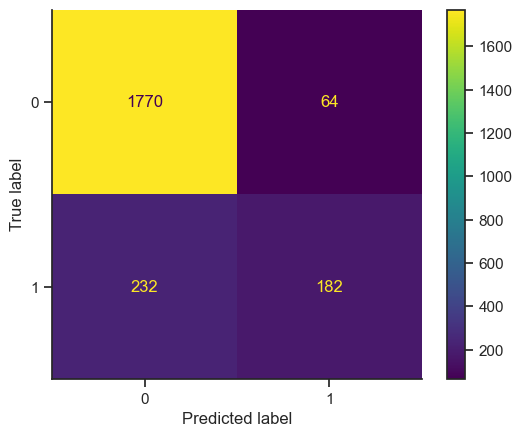

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4280
           1       0.72      0.44      0.55       965

    accuracy                           0.87      5245
   macro avg       0.80      0.70      0.73      5245
weighted avg       0.85      0.87      0.85      5245

ROC AUC: 0.87

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1834
           1       0.74      0.44      0.55       414

    accuracy                           0.87      2248
   macro avg       0.81      0.70      0.74      2248
weighted avg       0.86      0.87      0.85      2248

ROC AUC: 0.87



In [10]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Logistic Regression'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Decision Tree

In [11]:
model = DecisionTreeClassifier(random_state=42)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

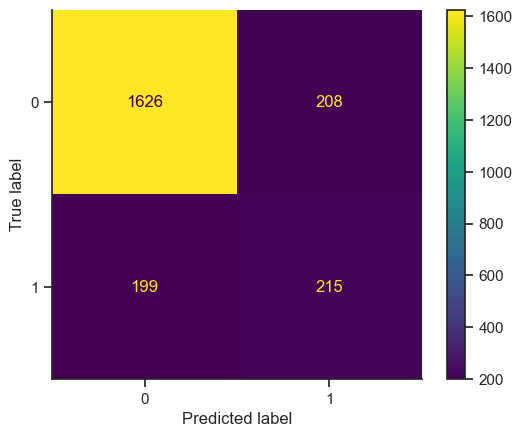

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4280
           1       1.00      1.00      1.00       965

    accuracy                           1.00      5245
   macro avg       1.00      1.00      1.00      5245
weighted avg       1.00      1.00      1.00      5245

ROC AUC: 1.00

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1834
           1       0.51      0.52      0.51       414

    accuracy                           0.82      2248
   macro avg       0.70      0.70      0.70      2248
weighted avg       0.82      0.82      0.82      2248

ROC AUC: 0.70



In [12]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Decision Tree'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Random Forest

In [13]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

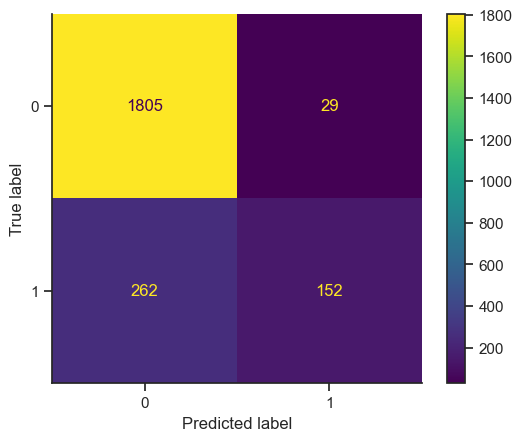

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4280
           1       1.00      1.00      1.00       965

    accuracy                           1.00      5245
   macro avg       1.00      1.00      1.00      5245
weighted avg       1.00      1.00      1.00      5245

ROC AUC: 1.00

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.87      0.98      0.93      1834
           1       0.84      0.37      0.51       414

    accuracy                           0.87      2248
   macro avg       0.86      0.68      0.72      2248
weighted avg       0.87      0.87      0.85      2248

ROC AUC: 0.89



In [14]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Random Forest'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

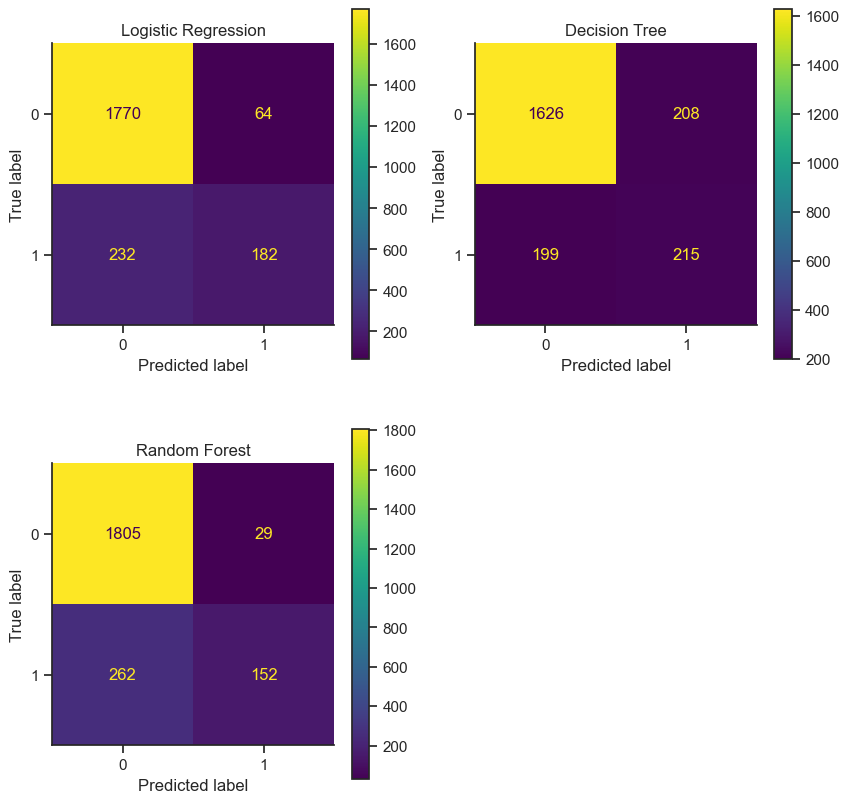

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.delaxes(axs[1, 1])

for model, cm in confusion_plots.items():
    ax = axs[list(confusion_plots.keys()).index(model) // 2, list(confusion_plots.keys()).index(model) % 2]
    display_cm = cm.plot(values_format='d', ax=ax)
    ax.set_title(model)

plt.show()

#### With smote

In [16]:
x_train, x_test, y_train, y_test = create_train()

In [17]:
confusion_plots = {}

##### Logistic Regression

In [18]:
model = LogisticRegression(solver='liblinear', random_state=42)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

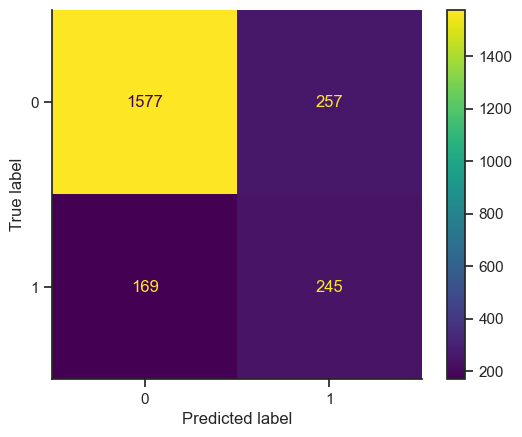

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      4280
           1       0.85      0.82      0.83      4280

    accuracy                           0.84      8560
   macro avg       0.84      0.84      0.84      8560
weighted avg       0.84      0.84      0.84      8560

ROC AUC: 0.92

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1834
           1       0.49      0.59      0.53       414

    accuracy                           0.81      2248
   macro avg       0.70      0.73      0.71      2248
weighted avg       0.83      0.81      0.82      2248

ROC AUC: 0.82



In [19]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Logistic Regression'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Decision Tree

In [20]:
model = DecisionTreeClassifier(random_state=42)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

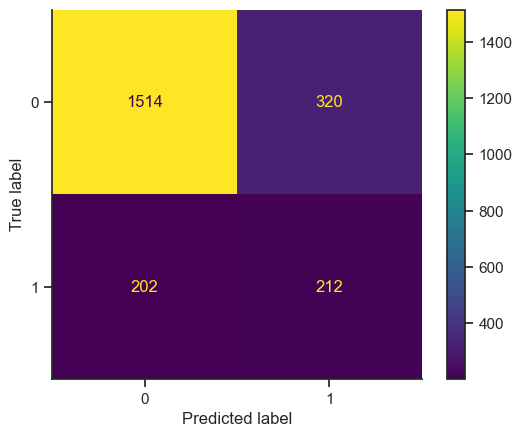

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4280
           1       1.00      1.00      1.00      4280

    accuracy                           1.00      8560
   macro avg       1.00      1.00      1.00      8560
weighted avg       1.00      1.00      1.00      8560

ROC AUC: 1.00

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1834
           1       0.40      0.51      0.45       414

    accuracy                           0.77      2248
   macro avg       0.64      0.67      0.65      2248
weighted avg       0.79      0.77      0.78      2248

ROC AUC: 0.67



In [21]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Decision Tree'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Random Forest

In [22]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

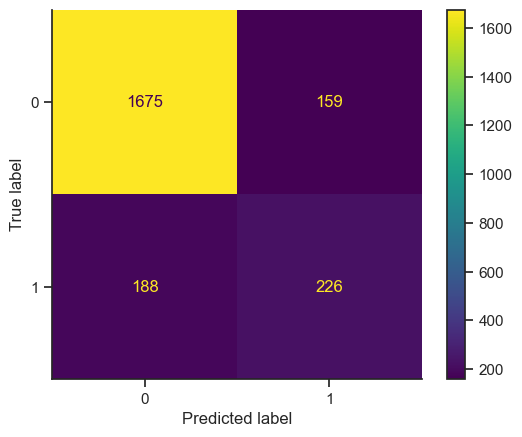

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4280
           1       1.00      1.00      1.00      4280

    accuracy                           1.00      8560
   macro avg       1.00      1.00      1.00      8560
weighted avg       1.00      1.00      1.00      8560

ROC AUC: 1.00

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1834
           1       0.59      0.55      0.57       414

    accuracy                           0.85      2248
   macro avg       0.74      0.73      0.74      2248
weighted avg       0.84      0.85      0.84      2248

ROC AUC: 0.86



In [23]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Random Forest'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

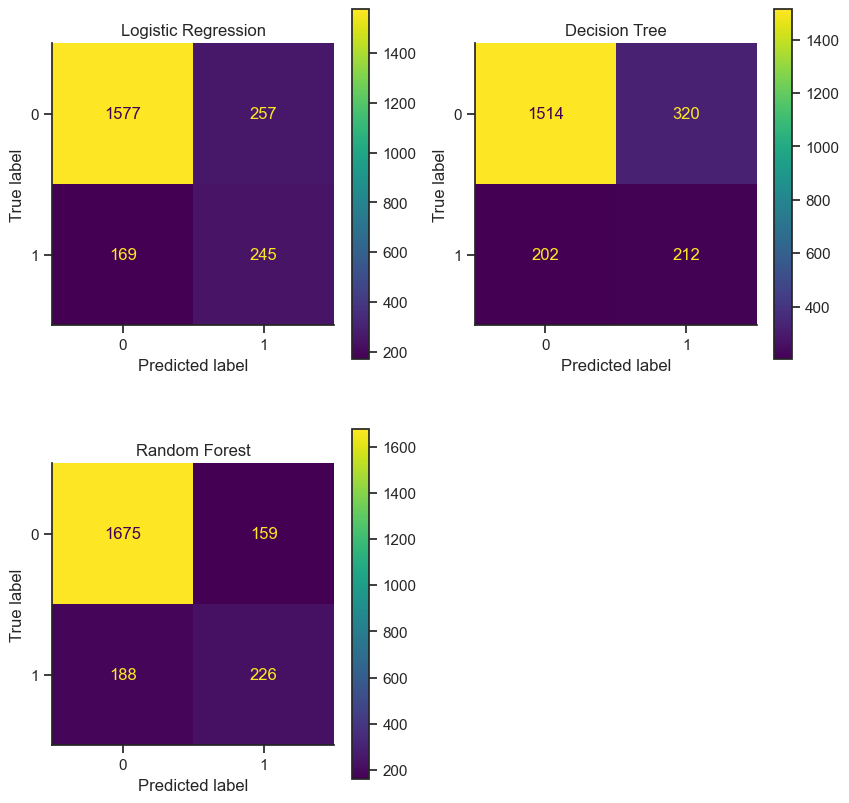

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.delaxes(axs[1, 1])

for model, cm in confusion_plots.items():
    ax = axs[list(confusion_plots.keys()).index(model) // 2, list(confusion_plots.keys()).index(model) % 2]
    display_cm = cm.plot(values_format='d', ax=ax)
    ax.set_title(model)

plt.show()

### Feature selection

In [25]:
features = x_train
target = y_train

models = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42, n_jobs=-1)
}

#### RFECV - Recursive Feature Elimination with Cross-Validation

In [26]:
# text = [
#     f"Feature Selection with {len(features.columns)} features",
#     f"{'-':-^50}",
#     f"{'Model':<30} {'Features Selected':<20}"
# ]

# print(*text, sep='\n')

# feature_rfecv = {
#     'LogisticRegression': [],
#     'DecisionTreeClassifier': [],
#     'RandomForestClassifier': []
# }
# for name, model in models.items():
#     est = model
#     cv = KFold(5)

#     rfecv = RFECV(
#         estimator=est,
#         step=1,
#         cv=cv,
#         scoring="f1",
#         n_jobs=-1
#     )
#     rfecv.fit(features, target)

#     feature_rfecv[name] = features.columns[rfecv.support_].tolist()
#     print(f"{model.__class__.__name__:<30} {len(feature_rfecv[name]):<20}")

#### SelectFromModel - feature selection based on importance of the features

In [27]:
# text = [
#     f"Feature Selection with {len(features.columns)} features",
#     f"{'-':-^50}",
#     f"{'Model':<30} {'Features Selected':<20}"
# ]

# print(*text, sep='\n')

# feature_select_from_model = {
#     'LogisticRegression': [],
#     'DecisionTreeClassifier': [],
#     'RandomForestClassifier': []
# }
# for name, model in models.items():
#     est = model

#     select_from_model = SelectFromModel(
#         estimator=est
#     )
    
#     select_from_model.fit(features, target)

#     feature_select_from_model[name] = features.columns[select_from_model.get_support()].tolist()
#     print(f"{model.__class__.__name__:<30} {len(feature_select_from_model[name]):<20}")

#### Test cross-validation with selected features

In [28]:
# feature_selection = {
#     'RFECV': feature_rfecv,
#     'SelectFromModel': feature_select_from_model
# }

In [29]:
# list_to_df = []

# for feature_selected, features_per_model in feature_selection.items():
#     for model_name, features_ in features_per_model.items():
#         cv = KFold(5)
#         model = models[model_name]
#         x = features[features_]
#         y = target
        
#         scores = cross_val_score(model, x, y, cv=cv, scoring='f1', n_jobs=-1)
        
#         list_to_df.append([feature_selected, model_name, len(features_), *scores, np.mean(scores), np.std(scores)])

In [30]:
# pd.DataFrame(list_to_df, columns=['Feature Selection', 'Model', 'Number of Features', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'Score Mean', 'Score Std']).sort_values('Model', ascending=False)

| Feature Selection | Model | Number of Features | CV1 | CV2 | CV3 | CV4 | CV5 | Score Mean | Score Std |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| RFECV | RandomForestClassifier | 59 | 0.656338 | 0.659740 | 0.680965 | 0.967229 | 0.971154 | 0.787085 | 0.148934 |
| SelectFromModel | RandomForestClassifier | 24 | 0.626573 | 0.614796 | 0.626632 | 0.955712 | 0.961795 | 0.757102 | 0.164716 |
| RFECV | LogisticRegression | 59 | 0.527443 | 0.501253 | 0.514360 | 0.901722 | 0.893342 | 0.667624 | 0.187920 |
| SelectFromModel | LogisticRegression | 21 | 0.446499 | 0.460177 | 0.501971 | 0.889269 | 0.878847 | 0.635353 | 0.203915 |
| RFECV | DecisionTreeClassifier | 16 | 0.472081 | 0.521437 | 0.512077 | 0.926157 | 0.921235 | 0.670597 | 0.207324 |
| SelectFromModel | DecisionTreeClassifier | 12 | 0.488491 | 0.507975 | 0.484061 | 0.912913 | 0.909207 | 0.660530 | 0.204719 |

In [31]:
# perfect_features = {
#     'LogisticRegression': feature_rfecv['LogisticRegression'],
#     'DecisionTreeClassifier': feature_rfecv['DecisionTreeClassifier'],
#     'RandomForestClassifier': feature_select_from_model['RandomForestClassifier']
# }

In [32]:
perfect_features = {
    'LogisticRegression': [
        'gender',
		'age_group',
		'weight_range',
		'idealweight_range',
		'IMC_range',
		'daysinICU',
		'firstnutrition',
		'avgdaily_Kcal_firstICU7days',
		'avgdaily_KcalKg_firstICU7days',
		'avgdaily_Kcal_firstNT7days',
		'avgdaily_KcalKg_firstNT7days',
		'avgdaily_Kcal_ICUdays',
		'avgdaily_KcalKg_ICUdays',
		'avgdaily_Kcal_NTdays',
		'avgdaily_KcalKg_NTdays',
		'avgdaily_g_firstICU7days',
		'avgdaily_gKg_firstICU7days',
		'avgdaily_g_firstNT7days',
		'avgdaily_gKg_firstNT7days',
		'avgdaily_g_ICUdays',
		'avgdaily_gKg_ICUdays',
		'avgdaily_g_NTdays',
		'avgdaily_gKg_NTdays',
		'hightemperature_days',
		'constipation',
		'diarrhea',
		'MV_start',
		'MV_return',
		'MV_weaning',
		'hemodialysis',
		'FB72H',
		'FB72hvariation',
		'FB72htrend',
		'FBtrend',
		'HGThyper_days',
		'HGThypo_days',
		'noraTo025days',
		'nora025to050days',
		'noraupto050days',
		'norafreedays',
		'vaso_days',
		'high_urea_days',
		'high_creatinine_days',
		'low_totallynpho_days',
		'low_hemoglobine_days',
		'high_bilirubins_days',
		'hypo_albumin_days',
		'high_triglycerides_days',
		'hyper_potassium_days',
		'hypo_potassium_days',
		'hyper_magnesium_days',
		'hypo_magnesium_days',
		'hyper_sodium_days',
		'hypo_sodium_days',
		'hypo_phosphor',
		'max_ast',
		'max_alt',
		'max_alkaline',
		'MV_stay'
	],
  	'DecisionTreeClassifier': [
      	'age_group',
		'IMC_range',
		'avgdaily_Kcal_firstICU7days',
		'avgdaily_KcalKg_firstICU7days',
		'avgdaily_Kcal_firstNT7days',
		'avgdaily_Kcal_ICUdays',
		'avgdaily_KcalKg_ICUdays',
		'avgdaily_Kcal_NTdays',
		'avgdaily_g_firstICU7days',
		'avgdaily_gKg_NTdays',
		'HGThyper_days',
		'noraTo025days',
		'norafreedays',
		'high_urea_days',
		'high_creatinine_days',
		'MV_stay'
    ],
  	'RandomForestClassifier': [
       	'gender',
		'age_group',
		'IMC_range',
		'avgdaily_Kcal_firstICU7days',
		'avgdaily_KcalKg_firstICU7days',
		'avgdaily_Kcal_firstNT7days',
		'avgdaily_KcalKg_firstNT7days',
		'avgdaily_Kcal_ICUdays',
		'avgdaily_KcalKg_ICUdays',
		'avgdaily_Kcal_NTdays',
		'avgdaily_KcalKg_NTdays',
		'avgdaily_g_firstICU7days',
		'avgdaily_gKg_firstICU7days',
		'avgdaily_g_firstNT7days',
		'avgdaily_gKg_firstNT7days',
		'avgdaily_g_ICUdays',
		'avgdaily_g_NTdays',
		'avgdaily_gKg_NTdays',
		'noraTo025days',
		'norafreedays',
		'high_urea_days',
		'high_creatinine_days',
		'low_hemoglobine_days',
		'MV_stay'
  	]
}

In [33]:
for feature in perfect_features.values():
    print(len(feature))

59
16
24


### Hyperparameter tuning

In [34]:
best_params = {
    'LogisticRegression': {},
    'DecisionTreeClassifier': {},
    'RandomForestClassifier': {}
}

#### Logistic Regression

In [35]:
# param_grid = [
#     {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': np.arange(100, 1001, 100)},
#     {'penalty': ['l2'], 'solver': ['newton-cg'], 'max_iter': np.arange(100, 1001, 100)},
# ]

# default = {
#     'tol': [1e-4, 1e-3, 1e-2],
#     'C': np.arange(0.5, 1.6, 0.5),
#     'class_weight': [None, 'balanced'],
#     'random_state': [42]
# }

# for grid in param_grid:
#     grid.update(default)

In [36]:
# features_for_grid = perfect_features['LogisticRegression']

# grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features[best_features], target)
# grid.best_params_

In [37]:
# print(f'Best score: {grid.best_score_}')    
# print(f'Best params: {grid.best_params_}')

In [38]:
best_params['LogisticRegression'] = {'C': 1.0, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.001}

#### Decision Tree

In [39]:
# param_grid = {
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': np.arange(1, 10),
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': np.arange(1, 5),
#     'min_samples_split': np.arange(2, 10),
#     'random_state': [42]
# }

In [40]:
# features_for_grid = perfect_features['DecisionTreeClassifier']

# grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features[features_for_grid], target)
# grid.best_params_

In [41]:
# print(f'Best score: {grid.best_score_}')    
# print(f'Best params: {grid.best_params_}')

In [42]:
best_params['DecisionTreeClassifier'] = {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}

#### Random Forest

In [43]:
# param_grid = {
#     'n_estimators': np.arange(100, 1001, 100),
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(3, 10),
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_leaf': np.arange(1, 5),
#     'min_samples_split': np.arange(3, 10),
#     'random_state': [42]
# }

In [44]:
# features_for_grid = perfect_features['RandomForestClassifier']

# grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
# # grid = RandomizedSearchCV(RandomForestClassifier(), n_iter=2000, param_distributions=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# grid.fit(features[features_for_grid], target)
# grid.best_params_

In [45]:
# print(f'Best score: {grid.best_score_}')    
# print(f'Best params: {grid.best_params_}')

In [46]:
best_params['RandomForestClassifier'] = {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 800, 'random_state': 42}

### Final models

In [47]:
model_list = []

In [48]:
confusion_plots = {}

##### Logistic Regression

In [49]:
best_features = perfect_features['LogisticRegression']
x_train, x_test, y_train, y_test = create_train(features=best_features)

params = best_params['LogisticRegression']
model = LogisticRegression(**params)

model.fit(x_train, y_train)

model_list.append(model)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

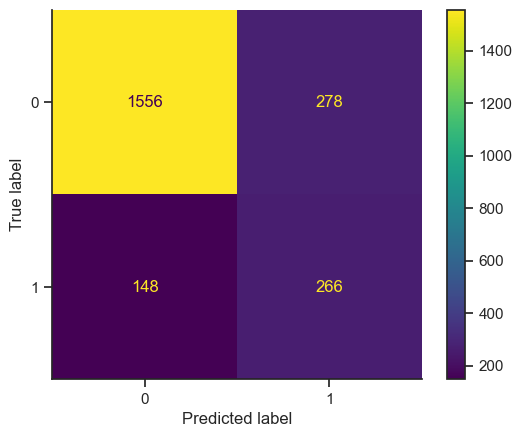

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      4280
           1       0.83      0.80      0.81      4280

    accuracy                           0.82      8560
   macro avg       0.82      0.82      0.82      8560
weighted avg       0.82      0.82      0.82      8560

ROC AUC: 0.90

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1834
           1       0.49      0.64      0.56       414

    accuracy                           0.81      2248
   macro avg       0.70      0.75      0.72      2248
weighted avg       0.84      0.81      0.82      2248

ROC AUC: 0.83



In [50]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Logistic Regression'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Decision Tree

In [51]:
best_features = perfect_features['DecisionTreeClassifier']
x_train, x_test, y_train, y_test = create_train(features=best_features)

params = best_params['DecisionTreeClassifier']
model = DecisionTreeClassifier(**params)

model.fit(x_train, y_train)

model_list.append(model)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

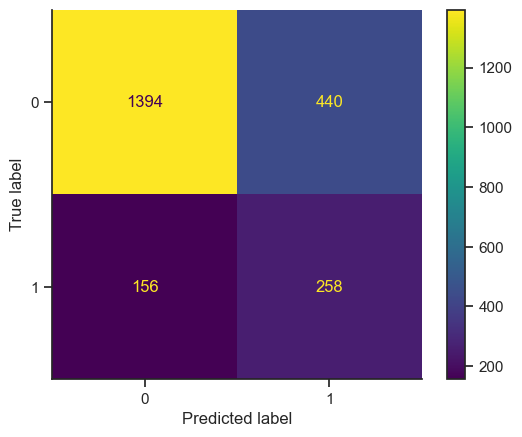

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4280
           1       0.83      0.85      0.84      4280

    accuracy                           0.84      8560
   macro avg       0.84      0.84      0.84      8560
weighted avg       0.84      0.84      0.84      8560

ROC AUC: 0.92

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1834
           1       0.37      0.62      0.46       414

    accuracy                           0.73      2248
   macro avg       0.63      0.69      0.64      2248
weighted avg       0.80      0.73      0.76      2248

ROC AUC: 0.75



In [52]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Decision Tree'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

##### Random Forest

In [53]:
best_features = perfect_features['RandomForestClassifier']
x_train, x_test, y_train, y_test = create_train(features=best_features)

params = best_params['RandomForestClassifier']
model = RandomForestClassifier(**params)

model_list.append(model)

model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

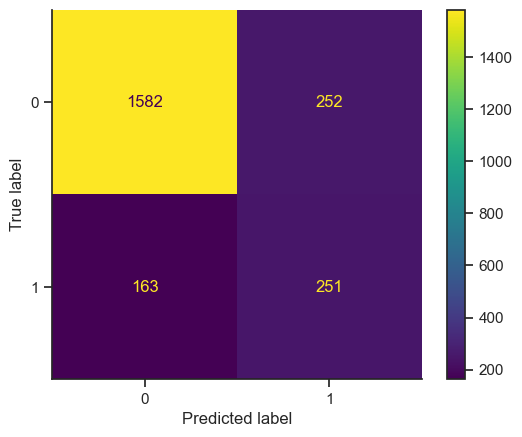

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4280
           1       0.92      0.92      0.92      4280

    accuracy                           0.92      8560
   macro avg       0.92      0.92      0.92      8560
weighted avg       0.92      0.92      0.92      8560

ROC AUC: 0.97

----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1834
           1       0.50      0.61      0.55       414

    accuracy                           0.82      2248
   macro avg       0.70      0.73      0.72      2248
weighted avg       0.83      0.82      0.82      2248

ROC AUC: 0.85



In [54]:
cm = confusion_matrix(y_test, pred_test, labels=model.classes_)
confusion_plots['Random Forest'] = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
display_cm = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='d')
plt.show()

print(f'{"Train":-^60}\n{classification_report(y_train, pred_train)}')
print(f'ROC AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]):.2f}', end='\n\n')

print(f'{"Test":-^60}\n{classification_report(y_test, pred_test)}')
print(f'ROC AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.2f}', end='\n\n')

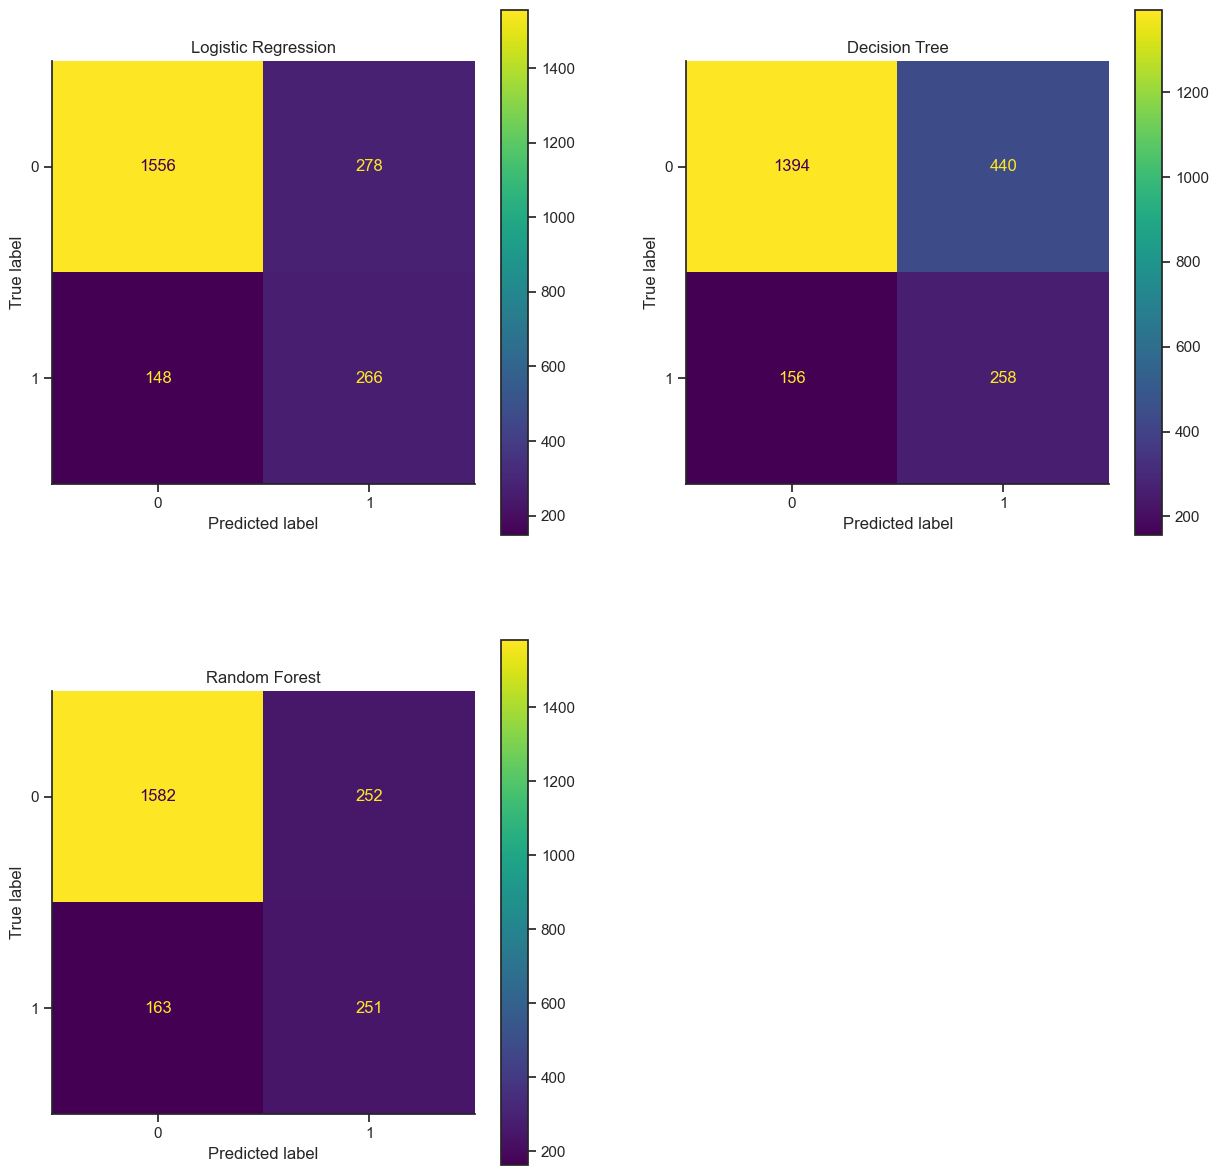

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.delaxes(axs[1, 1])

for model, cm in confusion_plots.items():
    ax = axs[list(confusion_plots.keys()).index(model) // 2, list(confusion_plots.keys()).index(model) % 2]
    display_cm = cm.plot(values_format='d', ax=ax)
    ax.set_title(model)

plt.show()

In [56]:
def plot_auc(model_list, features_dict, ax):
    sns.lineplot(x=[0, 1], y=[0, 1], ax=ax, linestyle='--', color='gray')
    
    for model, feature in zip(model_list, features_dict.values()):
        _, x_test, _, y_test = create_train(feature)
        y_pred = model.predict_proba(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
            
        sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()

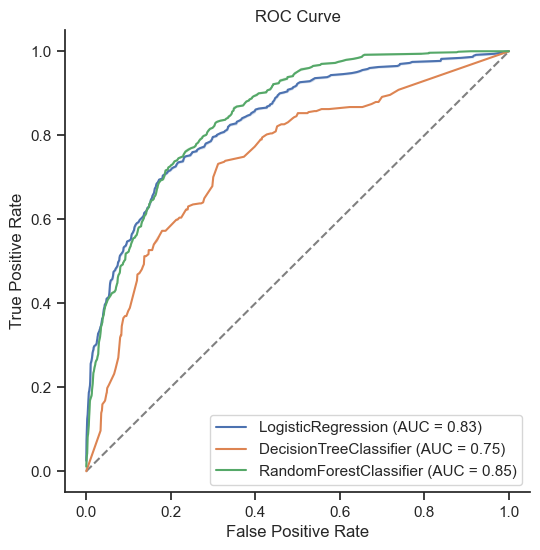

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_auc(model_list, perfect_features, ax)

plt.show()

## Analysis of the importance of the features

In [58]:
best_features = perfect_features['RandomForestClassifier']
x_train, x_test, y_train, y_test = create_train(features=best_features)

params = best_params['RandomForestClassifier']
model = RandomForestClassifier(**params)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_split=4, n_estimators=800,
                       random_state=42)

### Analysis on model feature importance

In [59]:
importance = pd.DataFrame(model.feature_importances_, index=x_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)
importance.head(15)

,importance
norafreedays,0.242636
MV_stay,0.077781
high_creatinine_days,0.066024
high_urea_days,0.050201
avgdaily_g_ICUdays,0.045272
avgdaily_g_NTdays,0.038936
avgdaily_g_firstNT7days,0.036981
noraTo025days,0.034850
avgdaily_g_firstICU7days,0.034571
avgdaily_gKg_firstNT7days,0.031136


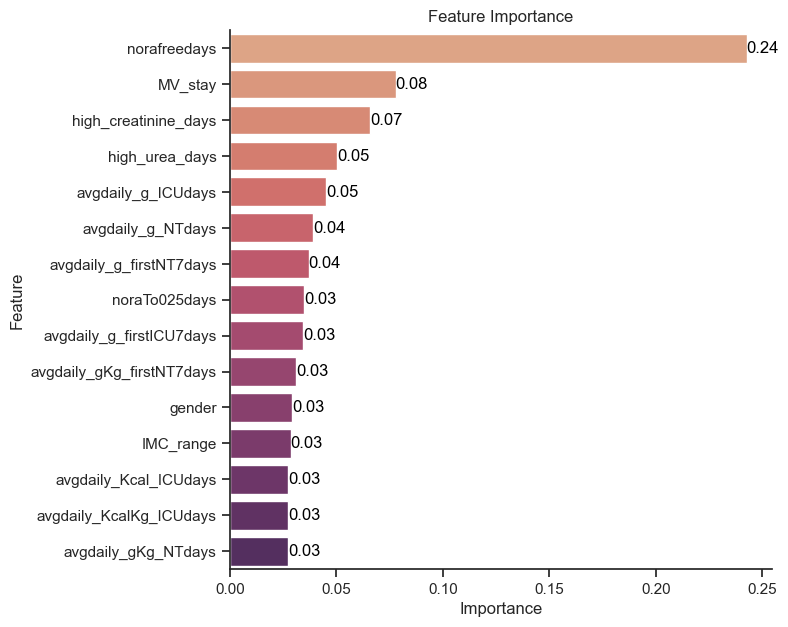

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.barplot(x='importance', y=importance[:15].index, data=importance[:15], ax=ax, palette='flare')
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
for i, v in enumerate(importance[:15].values):
    ax.text(v, i, f'{v[0]:.2f}', color='black', va='center')

plt.show()

### Analysis on SHAP values

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

In [63]:
def feature_importances_shap_values(shap_values, features):
    importances = [np.mean(np.abs(shap_values[:, i])) for i in range(shap_values.shape[1])]
    feature_importances = {feature: importance for importance, feature in zip(importances, features)}
    
    return pd.DataFrame(feature_importances.values(), index=feature_importances.keys(), columns=['importance']).sort_values(by='importance', ascending=False)

In [64]:
shap_feature_importance = feature_importances_shap_values(shap_values, x_test.columns)
shap_feature_importance.head(15)

,importance
norafreedays,0.138603
MV_stay,0.057571
high_creatinine_days,0.043300
high_urea_days,0.042843
gender,0.033491
avgdaily_g_ICUdays,0.026108
low_hemoglobine_days,0.024299
IMC_range,0.022754
avgdaily_g_firstICU7days,0.021256
avgdaily_g_NTdays,0.017390


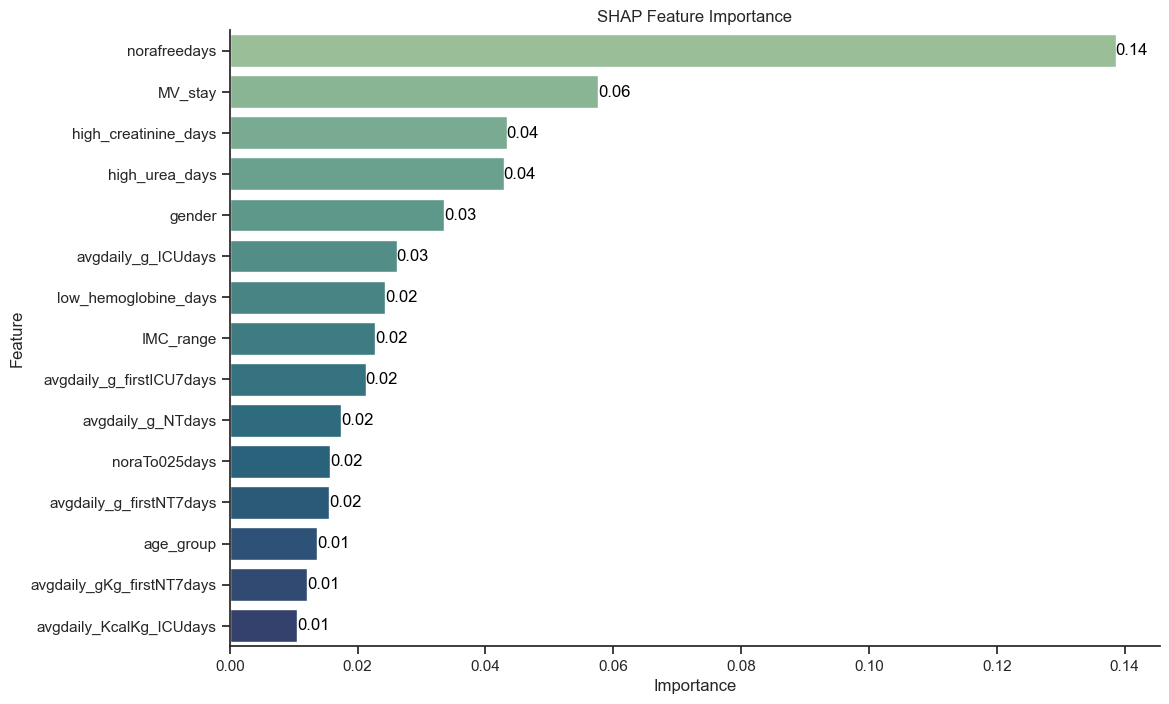

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.barplot(x='importance', y=shap_feature_importance[:15].index, data=shap_feature_importance[:15], ax=ax, palette='crest')
ax.set_title('SHAP Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
for i, v in enumerate(shap_feature_importance[:15].values):
    ax.text(v, i, f'{v[0]:.2f}', color='black', va='center')

plt.show()

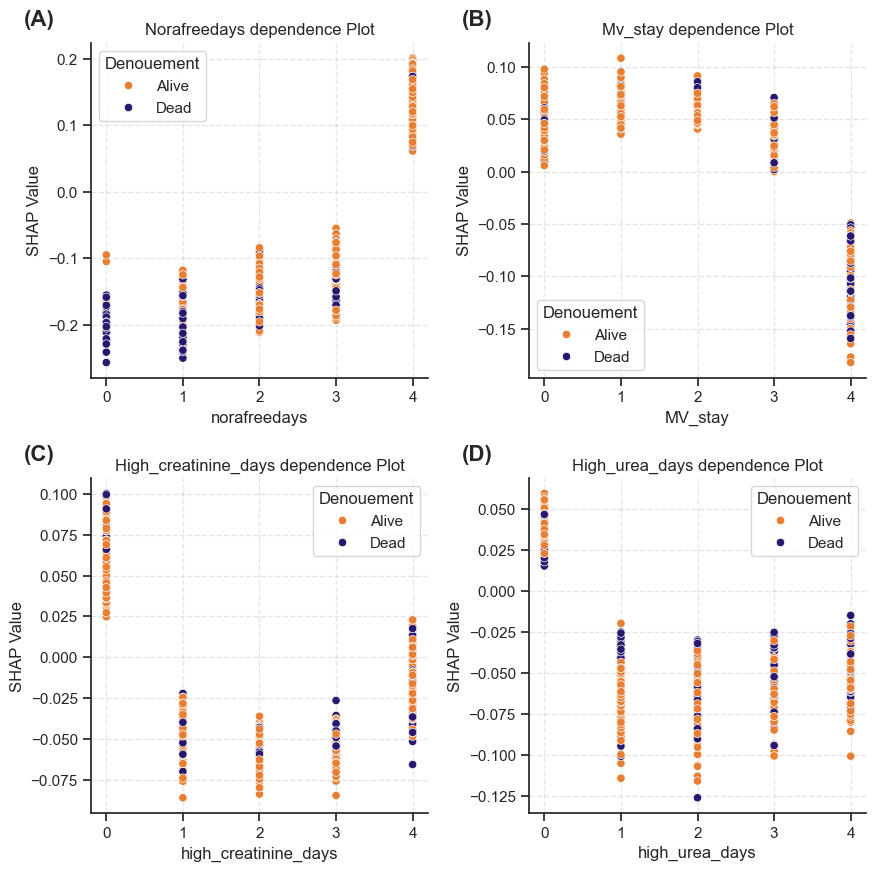

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

feature_shap_dict = {x_test.columns[i]: shap_values[:, i, 0] for i in range(shap_values.shape[1])}

map_label = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

for i, feature in enumerate(shap_feature_importance.index[:4]):
    sns.scatterplot(x=x_test[feature], y=feature_shap_dict[feature], hue=y_test.map({0: 'Alive', 1: 'Dead'}), ax=ax[i // 2, i % 2], palette=['#e87e31', '#29176d'])
    ax.flatten()[i].text(-.2, 1.1, f'({map_label.get(i)})', transform=ax.flatten()[i].transAxes, fontsize=16, fontweight='bold', va='top')
    ax.flatten()[i].set_title(f'{feature.capitalize()} dependence Plot')
    ax.flatten()[i].set_xlabel(feature)
    ax.flatten()[i].set_ylabel('SHAP Value')
    ax.flatten()[i].legend(title='Denouement')
    ax.flatten()[i].grid(axis='x', linestyle='--', alpha=.5)
    ax.flatten()[i].grid(axis='y', linestyle='--', alpha=.5)
    
plt.subplots_adjust(hspace=.3, wspace=.3)
    
plt.show()

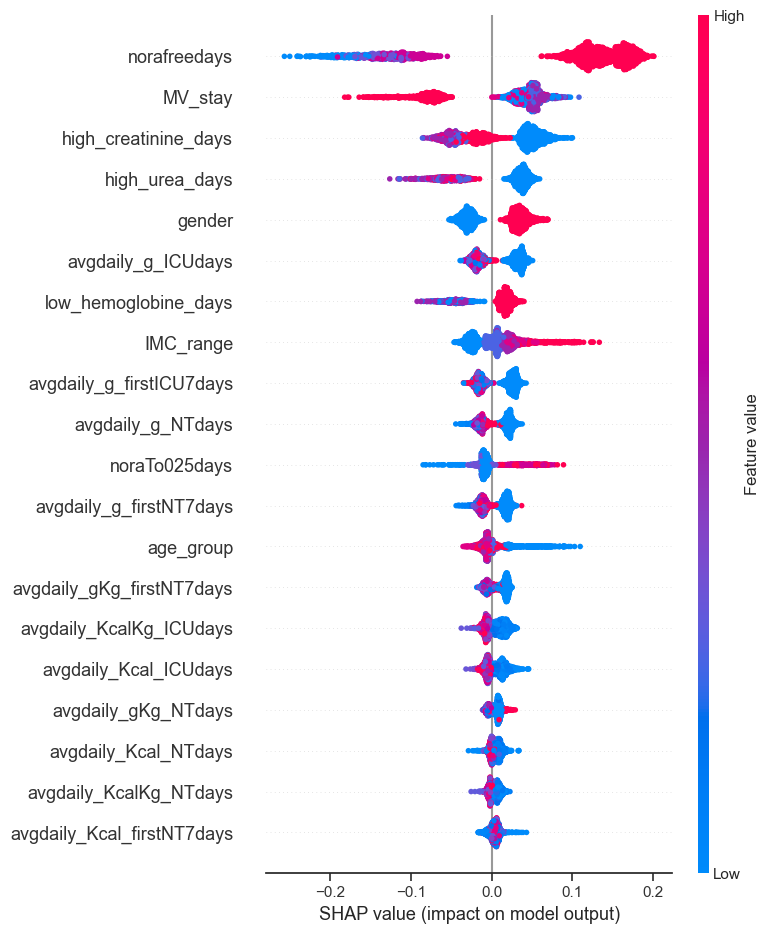

In [67]:
shap.summary_plot(shap_values=shap_values[:, :, 0], features=x_test, feature_names=x_test.columns, plot_type='dot', show=False)

In [68]:
shap_feature_importance.head(4)

,importance
norafreedays,0.138603
MV_stay,0.057571
high_creatinine_days,0.043300
high_urea_days,0.042843


In [69]:
sample = pd.concat((x_test, y_test), axis=1)

In [70]:
columns = [item for item in x_test.columns if 'avg' in item]
index = [x_test.columns.get_loc(column) for column in columns]

In [71]:
sample[sample['denouement'] == 0].sample(random_state=42)

,gender,age_group,IMC_range,avgdaily_Kcal_firstICU7days,avgdaily_KcalKg_firstICU7days,avgdaily_Kcal_firstNT7days,avgdaily_KcalKg_firstNT7days,avgdaily_Kcal_ICUdays,avgdaily_KcalKg_ICUdays,avgdaily_Kcal_NTdays,...,avgdaily_g_ICUdays,avgdaily_g_NTdays,avgdaily_gKg_NTdays,noraTo025days,norafreedays,high_urea_days,high_creatinine_days,low_hemoglobine_days,MV_stay,denouement
782,0,5,2,15.3,0.3,25.5,0.5,15.3,0.3,15.3,...,0.0,0.0,0.0,0,4,2,0,4,0,0


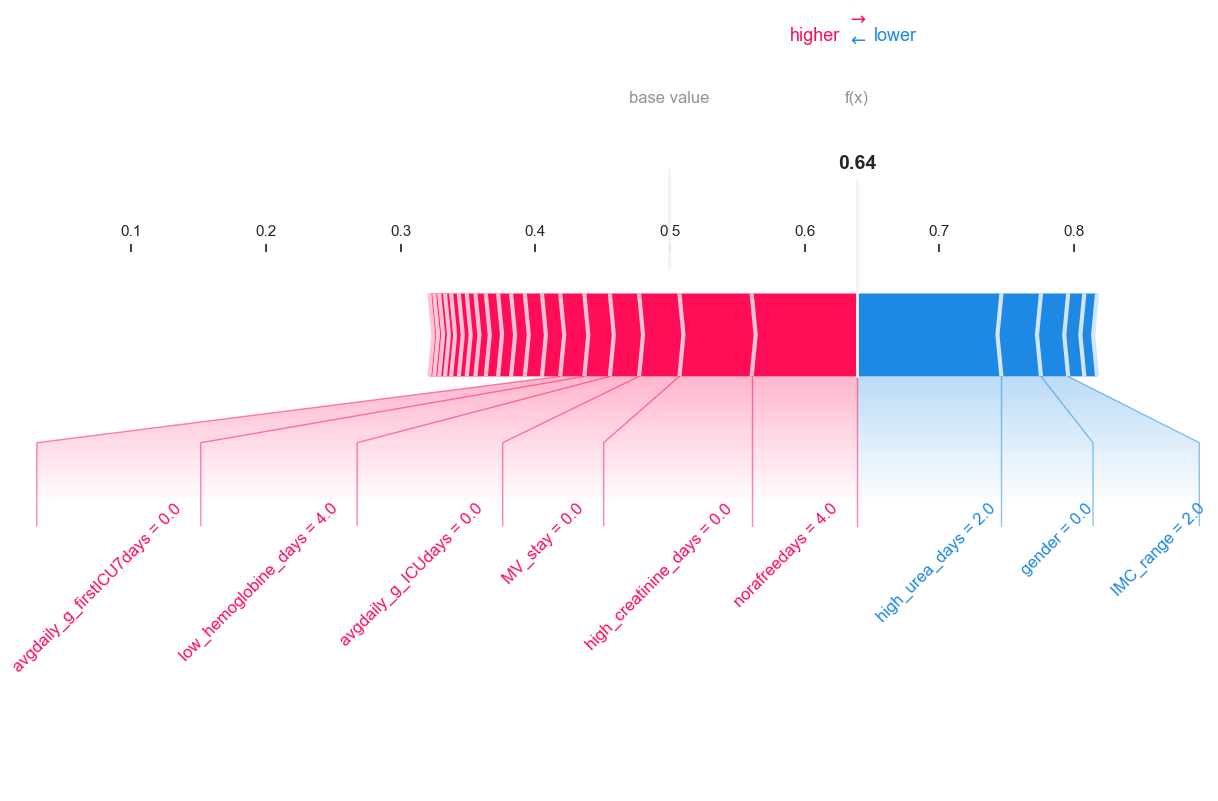

In [72]:
shap.plots.force(explainer.expected_value[0], shap_values[782][:, 0], x_test.iloc[782, :], matplotlib = True, text_rotation=45, figsize=(15, 7), show=False)

In [73]:
# shap.plots.force(explainer.expected_value[0], shap_values[782][index, 0], x_test.iloc[782, index], matplotlib = True, text_rotation=65, figsize=(15, 5))

In [74]:
sample[sample['denouement'] == 1].sample(random_state=42)

,gender,age_group,IMC_range,avgdaily_Kcal_firstICU7days,avgdaily_KcalKg_firstICU7days,avgdaily_Kcal_firstNT7days,avgdaily_KcalKg_firstNT7days,avgdaily_Kcal_ICUdays,avgdaily_KcalKg_ICUdays,avgdaily_Kcal_NTdays,...,avgdaily_g_ICUdays,avgdaily_g_NTdays,avgdaily_gKg_NTdays,noraTo025days,norafreedays,high_urea_days,high_creatinine_days,low_hemoglobine_days,MV_stay,denouement
1957,1,2,3,392.9,5.1,392.9,5.1,392.9,5.1,392.9,...,0.0,0.0,0.0,0,1,4,4,4,4,1


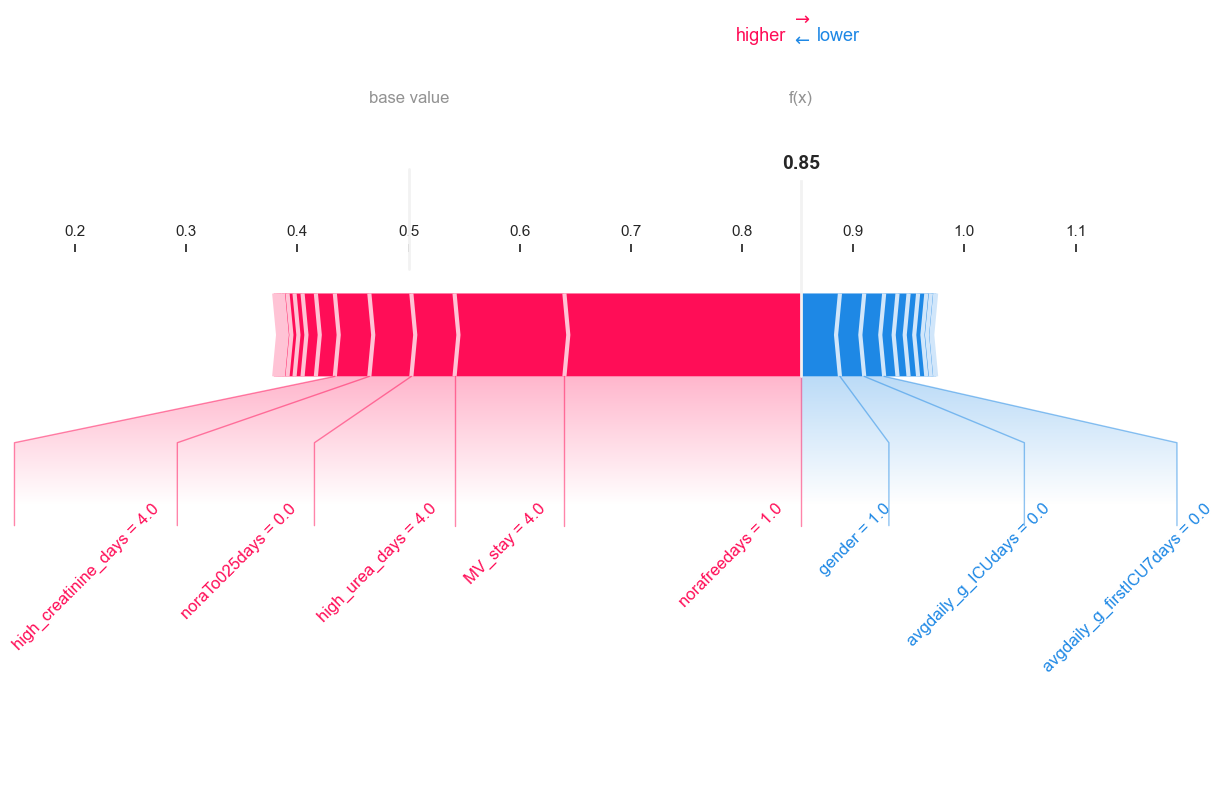

In [80]:
shap.plots.force(explainer.expected_value[1], shap_values[1957][:, 1], x_test.iloc[1957, :], matplotlib=True, text_rotation=45, figsize=(15, 7), show=False)

In [76]:
# shap.plots.force(explainer.expected_value[1], shap_values[1957][index, 1], x_test.iloc[1957, index], matplotlib = True, text_rotation=65, figsize=(15, 5))

In [77]:
# shap.plots.force(explainer.expected_value[0], shap_values[782][:, 0], x_test.iloc[782, :], matplotlib = True, text_rotation=45, show=False)
shap.plots.force(explainer.expected_value[1], shap_values[1957][:, 1], x_test.iloc[1957, :], matplotlib = True, text_rotation=45, show=False)
# Imagem transparente sem cortar as labels
plt.savefig('test.png', bbox_inches='tight', transparent=True)
